In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_percentage_error as mean_ape
from sklearn.metrics import root_mean_squared_error as root_mse

In [2]:
model_data_no_journal = pd.read_parquet("data/model_data_no_journal.parquet")
model_data_no_journal = model_data_no_journal[model_data_no_journal['political_alignment'] != 'autre']
model_data_no_journal['next_pres_votes_share'] = model_data_no_journal['pres_dummy'] * model_data_no_journal['pres_votes_share']

model_data = pd.read_parquet("data/model_data.parquet")
model_data = model_data[model_data['political_alignment'] != 'autre']
model_data['next_pres_votes_share'] = model_data['pres_dummy'] * model_data['pres_votes_share']

In [3]:
nuances_order = ["Far right", "Right", "Center", "Left", "Far left"]

variables_dict = {
    'government': 'Government Participation',
    'leg_votes_share': 'Vote Share in Last Legislative Election',
    'na_share': 'Share of MPs',
    'next_pres_votes_share': 'Vote Share in Next Presidential Election'}

In [4]:
outcome = "quotes_share"

Ce notebook utilise une approche économétrique classique cherchant à expliquer des phénomènes réels.
- Les outcomes sont la proportion de citations issues de chaque nuance politique
- Les régresseurs sont la proportion de sièges à l'Assemblée Nationale, la proportion des voix obtenues aux précédentes élections législatives et aux prochaines élections présidentielles, ainsi que la participation au gouvernement.
- Les contrôles sont les périodes et les journaux

*NB : les résultats aux précédentes élections présidentielles n'apportent rien par rapport à ceux des législatifs, et s'avèrent moins prédictifs lorsqu'utilisés seuls.*

On utilise des modèles linéaires en cohérence avec l'hypothèse de normes éditoriales prescrivant une proportionnalité entre la couverture médiatique et le poids politique de chaque parti.

Les contrôles sont utilisés en interaction complète avec les régresseurs. Formellement, ils indicent les outcomes et les régresseurs, au lieu d'apparaître comme des variables distinctes. Cela revient à estimer des modèles distincts pour chaque sous-ensemble de données défini par une combinaison de nuance politique et de contrôles. Cette approche semble préférable pour expliquer la couverture médiatique de chaque nuance politique, dans chaque journal, à chaque période. Elle permet aussi d'éviter les problèmes de colinéarité.

Il serait possible d'utiliser les nuances politiques comme contrôles. Mais les variables correspondantes tendent à capturer l'essentiel des effets, réduisant l'intérêt sociologique des modèles.

Ces derniers sont par ailleurs dépourvus de constantes, dont l'ajout aboutit le plus souvent à dégrager les performances des modèles, tout en compliquant leur interprétation (par exemple avec une constante très élevée et un coefficient négatif pour la proportion de sièges à l'Assemblée Nationale).

Comme les modèles ne concernent pas toujours les mêmes populations et sont dépourvus de constante, le $R^2$ ne constitue pas une mesure de performance satisfaisante ([Shalizi, 2004](https://www.stat.cmu.edu/~cshalizi/TALR/TALR.pdf)). On utilise à la place deux grandeurs reflétant la distance relative entre les valeurs réelles et prédites :
- $\text{Mean absolute percentage error (MAPE)} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{\hat{y}_i - y_i}{y_i} \right| \Rightarrow$ Elle s'interprète directement : une MAPE de 1 signifie que les valeurs prédites s'écartent en moyenne de 100 % des valeurs réelles.
- $\text{Root mean squared percentage error (RMSPE)} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2} \Rightarrow$ Elle ne s'interprète pas directement mais permet aussi de comparer les modèles, en étant plus sensible aux outliers que la MAPE.

*NB 1: la relativité des écarts entre valeurs réelles et prédites est essentielle : un écart de 5 points de pourcentage n'a pas la même signification lorsque les valeurs réelles gravitent autour de 50 % ou de 5 % par exemple.*

*NB 2 : les données brutes sont des citations datées. Afin de les exploiter, il est nécessaire de les périodiser — ici, en les agrégant en nombre de citations par mois. De surcroît, les outcomes sont relatifs, prenant la forme de proportions de citations mensuelles. Dans ce contexte, pour que l’écart entre les valeurs observées et les valeurs prédites reflète correctement la performance d'un modèle, il est indispensable que son niveau d'agrégation corresponde à celui des données. Par exemple, si l’on estime un modèle unique pour l’ensemble des journaux, ces derniers ne doivent pas apparaître dans les données : on doit connaître la proportion de citations de personnalités du  pour chaque période, mais pas dans chaque journal à chaque période. Dans le cas contraire, la MAPE ou la RMSPE risquent d’être biaisées, car elles seraient calculées en moyenne sur des journaux ayant des volumes très différents d’articles.*

## 1. Modèle de base = sièges à l'AN
De la forme $Y_{i} = \beta T_{i}$ avec :
- $Y_{i}$ la proportion des articles intégrant des citations de la nuance politique $i$ (avec $\sum_{i=1}^{n} Y_{i} = 1$)
- $\beta$ la pondération du nombre de sièges détenus les différentes nuances politiques représentées à l'Assemblée
- $T_{i}$ la proportion des sièges détenus par la nuance politique $i$

In [5]:
X = model_data_no_journal[["na_share"]]
y = model_data_no_journal[outcome]
model = sm.OLS(y, X).fit(cov_type='HC3')
y_pred = model.predict(X)
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

             coef  pval
na_share  0.90792   0.0

MAPE: 71.12%
RMSPE: 0.38013


## 2. Sièges à l'AN + participation au gouvernement
De la forme $Y_{i} = \beta T_{i} + \gamma G_{i}$ avec :
- $\gamma$ la proportion des articles intégrant des citations dont bénéficie la nuance politique du gouvernement
- $G_{i}$ une indicatrice valant 1 si le Premier ministre appartient à la nuance politique $i$

In [6]:
X = model_data_no_journal[["na_share", "government"]]
y = model_data_no_journal[outcome]
model = sm.OLS(y, X).fit(cov_type='HC3')
y_pred = model.predict(X)
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

                coef      pval
na_share    0.882946  0.000000
government  0.019752  0.007171

MAPE: 70.08%
RMSPE: 0.37940


## 3. Sièges à l'AN + participation au gouvernement + score aux présidentielles et aux législatives
Les modèles estimés sont de la forme $Y_{i} = \beta T_{i} + \gamma G_{i} + \theta P_{i} + \delta L_{i}$ avec :
- $\theta$ la pondération des résultats aux élections présidentielles des différentes nuances politiques
- $P_{i}$ la proportion des voix obtenues par la nuance politique $i$ à l'élection présidentielle suivante (pour le mois de l'élection et les quatre précédents)
- $\delta$ la pondération des résultats aux élections législatives des différentes nuances politiques
- $L_{i}$ la proportion des voix obtenues par la nuance politique $i$ à l'élection législative précédente

In [7]:
X = model_data_no_journal[["na_share", "government", "leg_votes_share", "next_pres_votes_share"]]
y = model_data_no_journal[outcome]
model = sm.OLS(y, X).fit(cov_type='HC3')
y_pred = model.predict(X)
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

                           coef           pval
na_share               0.476795  9.359891e-196
government             0.070054   2.227986e-25
leg_votes_share        0.724434  2.859663e-216
next_pres_votes_share  0.026288   5.693732e-01

MAPE: 62.22%
RMSPE: 0.31091


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = model_data_no_journal[["na_share", "pres_votes_share", "leg_votes_share", "government"]]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

In [ ]:
X.corr()

## 4. Sièges à l'AN + participation au gouvernement + score aux présidentielles et aux législatives // nuances politiques
Les modèles estimés sont de la forme $Y_{i} = \beta_{i} T_{i} + \gamma_{i} G_{i} + \theta_{i} P_{i} + \delta_{i} L_{i}$ : les effets deviennent spécifiques à chaque nuance politique.

In [8]:
models = {}

for alignment in model_data_no_journal["political_alignment"].unique():
    subset = model_data_no_journal[model_data_no_journal["political_alignment"] == alignment]

    if len(subset) >= 3:
        X = subset[["na_share", "government", "next_pres_votes_share", "leg_votes_share"]]
        y = subset[outcome]
        model = sm.OLS(y, X).fit(cov_type='HC3')      
        y_pred = model.predict(X)
        mape = mean_ape(y, y_pred)
        rmspe = root_mse(y, y_pred) / y.mean()
        
        models[alignment] = {
            "params": model.params.rename("params").to_frame(),
            "pvalues": model.pvalues.rename("pval").to_frame(),
            "mape": mape,
            "rmspe": rmspe}

    else:
        models[alignment] = {
            "params": None,
            "pvalues": None,
            "mape": None,
            "rmspe": None}

In [9]:
summary = []

for alignment, model_info in models.items():
    summary.append({
        "alignment": alignment,
        "mape": model_info["mape"],
        "rmspe": model_info["rmspe"]
    })

results = pd.DataFrame(summary)
results["alignment"] = pd.Categorical(results["alignment"], categories=nuances_order, ordered=True)
results = results.sort_values("alignment").reset_index(drop=True)

results.style.hide(axis="index") 

alignment,mape,rmspe
Far right,0.540136,0.600268
Right,0.152495,0.152991
Center,1.128226,0.503756
Left,0.227525,0.238993
Far left,0.407244,0.468271


In [10]:
results_list = []

for alignment, model_info in models.items():
    df = model_info["params"].join(model_info["pvalues"])
    df["alignment"] = alignment
    df["variable"] = df.index
    results_list.append(df.reset_index(drop=True))

results = pd.concat(results_list, ignore_index=True)
results = results.dropna(subset=["pval"])
results["alignment"] = pd.Categorical(results["alignment"], categories=nuances_order, ordered=True)
results = results.sort_values(["variable", "alignment"])
results = results.set_index(["variable", "alignment"])
results.index.names = ["", "Political Alignment"]
results.index = results.index.set_levels(
    results.index.levels[0].to_series().replace(variables_dict).values,
    level=0)

results.style.format("{:.4f}")

## 5. Sièges à l'AN + participation au gouvernement + score aux présidentielles et aux législatives // nuances politiques + périodes
Il s'agit maintenant d'étudier plus directement l'hypothèse d'une légitimation de l'extrême droite par la presse écrite nationale. La méthode la plus simple est d'estimer les modèles précédents pour 2 périodes, afin d'observer l'évolution des coefficients. Les modèles estimés sont de la forme $Y_{it} = \beta_{it} T_{it} + \gamma_{it} G_{it} + \theta_{it} P_{it} + \delta_{it} L_{it}$ : les effets deviennent spécifiques à chaque période $t$.

On retient 2017 comme charnière, avec l'idée que...
- La période précédente est encore marquée par le jeu fonctionnement traditionnel du système politique, avec une domination persistante de la droite et de la gauche de gouvernement, malgré leurs recompositions.
- La période suivante est caractérisée par l'effondrement de ce système, avec l'essort du centre et des extrêmes.

In [11]:
cutoff1 = pd.Period('2002-06', freq='M')
cutoff2 = pd.Period('2017-06', freq='M')

models = {}

for period_label, period_filter in {
    '1981-2002': model_data_no_journal["month"] < cutoff1,
    '2002-2017': (model_data_no_journal["month"] >= cutoff1) & (model_data_no_journal["month"] < cutoff2),
    '2017-2024': model_data_no_journal["month"] >= cutoff2
}.items():
    
    models[period_label] = {}
    period_data = model_data_no_journal[period_filter]
    
    for alignment in period_data["political_alignment"].unique():
        models[period_label][alignment] = {}
        subset = period_data[period_data["political_alignment"] == alignment]

        if len(subset) >= 3:
            X = subset[["na_share", "government", "next_pres_votes_share", "leg_votes_share"]]
            y = subset[outcome]
            model = sm.OLS(y, X).fit(cov_type='HC3')
            y_pred = model.predict(X)
            mape = mean_ape(y, y_pred)
            rmspe = root_mse(y, y_pred) / y.mean()

            models[period_label][alignment] = {
                "params": model.params.rename("params").to_frame(),
                "pvalues": model.pvalues.rename("pval").to_frame(),
                "mape": mape,
                "rmspe": rmspe}

        else:
            models[period_label][alignment] = {
                "params": None,
                "pvalues": None,
                "mape": None,
                "rmspe": None}

/opt/conda/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:2014: RuntimeWarning: divide by zero encountered in divide
  self.het_scale = (self.wresid / (1 - h))**2
/opt/conda/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1971: RuntimeWarning: invalid value encountered in multiply
  scale[:, None] * self.model.pinv_wexog.T)


In [12]:
summary_list = []

for period, alignment_dict in models.items():
    for alignment, model_info in alignment_dict.items():
        summary_list.append({
            "period": period,
            "alignment": alignment,
            "mape": model_info["mape"],
            "rmspe": model_info["rmspe"]
        })

summary = pd.DataFrame(summary_list)
summary["alignment"] = pd.Categorical(summary["alignment"], categories=nuances_order, ordered=True)
summary = summary.pivot_table(index="alignment",
                                      columns="period",
                                      values=["mape", "rmspe"],
                                      observed=False)
summary = summary.reset_index()
summary.columns.names = [None, None]

format_cols = summary.columns[1:]
summary.style.hide(axis="index").format({col: "{:.3f}" for col in format_cols})

In [13]:
results_list = []

for period, alignment_dict in models.items():
    for alignment, model_info in alignment_dict.items():
        df = model_info["params"].join(model_info["pvalues"])
        df["period"] = period
        df["alignment"] = alignment
        df["variable"] = df.index
        results_list.append(df.reset_index(drop=True))

results = pd.concat(results_list, ignore_index=True)
results = results.dropna(subset=["pval"])
results["alignment"] = pd.Categorical(results["alignment"], categories=nuances_order, ordered=True)
results = results.pivot_table(index=["variable", "alignment"],
                              columns="period",
                              values=["params", "pval"],
                              observed=False)
results.columns = results.columns.swaplevel(0, 1)
results = results.reindex(columns=["1981-2002", "2002-2017", "2017-2024"], level=0)
results = results.sort_index()
results.index.names = ["", "Political Alignment"]
results.columns.names = [None, None]
results.index = results.index.set_levels(
    results.index.levels[0].to_series().replace(variables_dict).values,
    level=0)

results.style.format({col: "{:.4f}" for col in results.columns})

## 6. Sièges à l'AN + participation au gouvernement + score aux présidentielles et aux législatives // nuances politiques + périodes + journaux
On différencie finalement selon les journaux. Les modèles estimés sont de la forme $Y_{ijt} = \beta_{ijt} T_{ijt} + \gamma_{ijt} G_{ijt} + \theta_{ijt} P_{ijt} + \delta_{ijt} L_{ijt}$ : les effets deviennent spécifiques à chaque journal $j$.

In [14]:
cutoff = pd.Period('2017-06', freq='M')

models = {}

for period_label, period_filter in {
    'pre2017': model_data["month"] < cutoff,
    'post2017': model_data["month"] >= cutoff
}.items():
    
    models[period_label] = {}
    period_data = model_data[period_filter]
    
    for alignment in period_data["political_alignment"].unique():
        models[period_label][alignment] = {}
        subset = period_data[period_data["political_alignment"] == alignment]
        
        for journal in period_data["journal"].unique():
            sub_subset = subset[subset["journal"] == journal]

            if len(subset) >= 3:
                X = sub_subset[["na_share", "government", "next_pres_votes_share", "leg_votes_share"]]
                y = sub_subset[outcome]            
                model = sm.OLS(y, X).fit(cov_type='HC3')
                y_pred = model.predict(X)
                mape = mean_ape(y, y_pred)
                rmspe = root_mse(y, y_pred) / y.mean()

                models[period_label][alignment][journal] = {
                    "params": model.params.rename("params").to_frame(),
                    "pvalues": model.pvalues.rename("pval").to_frame(),
                    "mape": mape,
                    "rmspe": rmspe}

            else:
                models[period_label][alignment][journal] = {
                    "params": None,
                    "pvalues": None,
                    "mape": None,
                    "rmspe": None}

/opt/conda/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:2014: RuntimeWarning: invalid value encountered in divide
  self.het_scale = (self.wresid / (1 - h))**2


In [15]:
summary = []

for period, alignment_dict in models.items():
    for alignment, journal_dict in alignment_dict.items():
        for journal, model_info in journal_dict.items():
            summary.append({
                "period": period,
                "alignment": alignment,
                "journal": journal,
                "mape": model_info["mape"],
                "rmspe": model_info["rmspe"]
            })

results = pd.DataFrame(summary)
results["alignment"] = pd.Categorical(results["alignment"], categories=nuances_order, ordered=True)
results = results.pivot_table(index=["alignment", "journal"],
                              columns="period",
                              values=["mape", "rmspe"],
                              observed=False)
results.index.names = ["Political alignment", "Journal"]
results.columns.names = [None, None]

format_cols = results.columns
results.style.format({col: "{:.3f}" for col in format_cols})

In [16]:
results_list = []

for period, alignment_dict in models.items():
    for alignment, journal_dict in alignment_dict.items():
        for journal, model_info in journal_dict.items():
            df = model_info["params"].join(model_info["pvalues"])
            df["period"] = period
            df["alignment"] = alignment
            df["journal"] = journal
            df["variable"] = df.index
            results_list.append(df.reset_index(drop=True))

results = pd.concat(results_list, ignore_index=True)
results = results.dropna(subset=["pval"])
results["alignment"] = pd.Categorical(results["alignment"], categories=nuances_order, ordered=True)
results = results.pivot_table(index=["variable", "alignment", "journal"],
                              columns="period",
                              values=["params", "pval"],
                              observed=False)

results.columns = results.columns.swaplevel(0, 1)
results = results.reindex(columns=["pre2017", "post2017"], level=0)
results = results.sort_index()
results.index.names = ["", "Political alignment", "Journal"]
results.index = results.index.set_levels(
    results.index.levels[0].to_series().replace(variables_dict).values,
    level=0)

results.style.format({col: "{:.4f}" for col in results.columns})

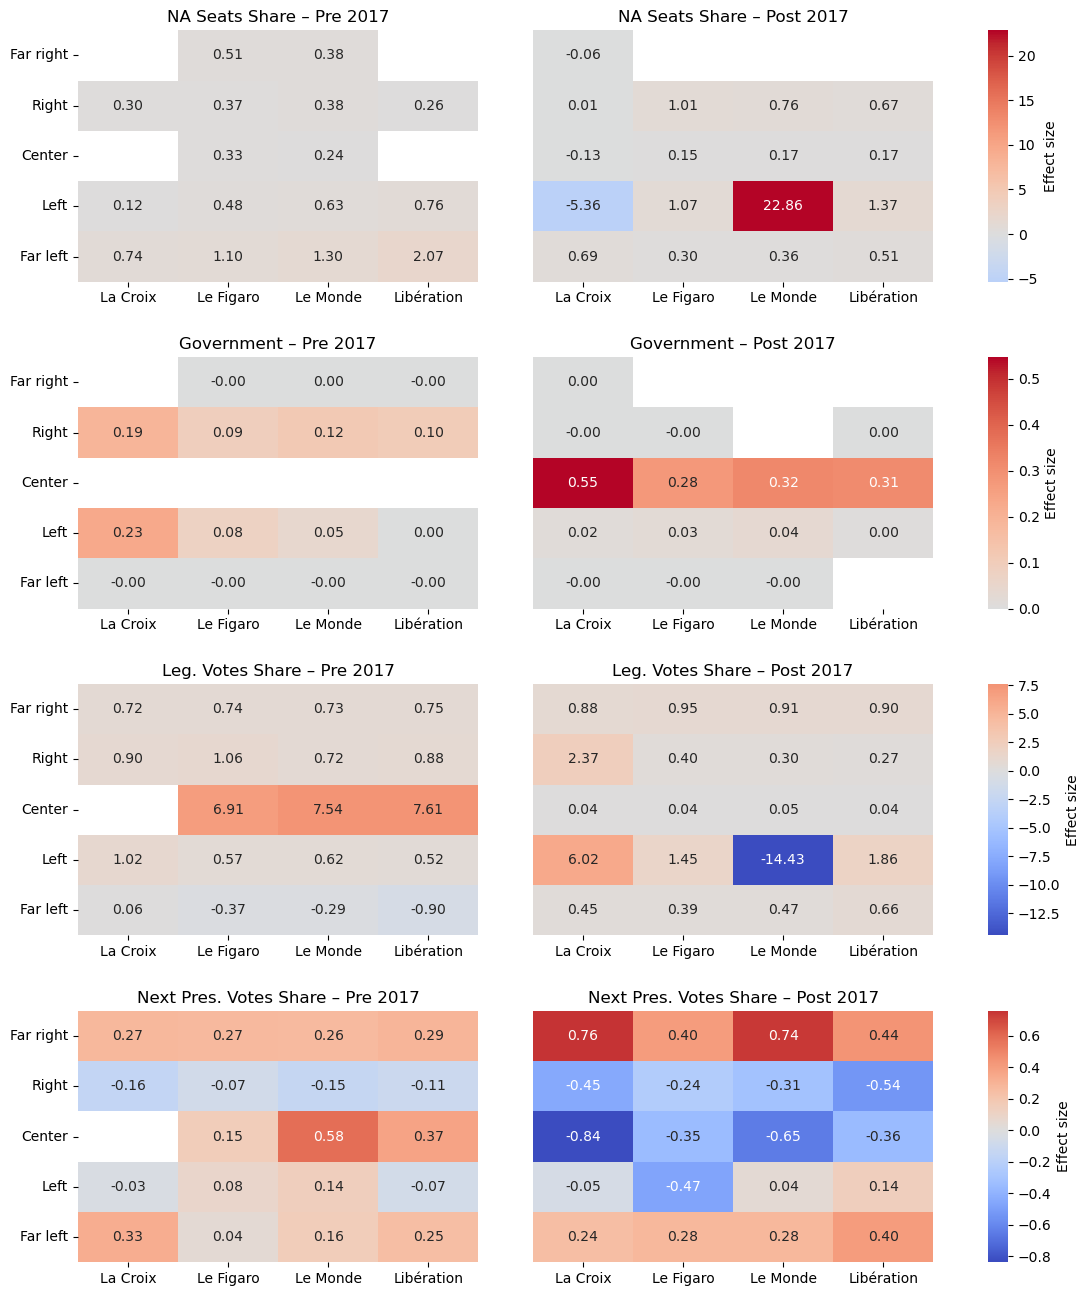

In [17]:
combinations = [
    ('na_share', 'pre2017'),
    ('na_share', 'post2017'),
    ('government', 'pre2017'),
    ('government', 'post2017'),
    ('leg_votes_share', 'pre2017'),
    ('leg_votes_share', 'post2017'),
    ('next_pres_votes_share', 'pre2017'),
    ('next_pres_votes_share', 'post2017'),]

titles = [
    'NA Seats Share – Pre 2017',
    'NA Seats Share – Post 2017',
    'Government – Pre 2017',
    'Government – Post 2017',
    'Leg. Votes Share – Pre 2017',
    'Leg. Votes Share – Post 2017',
    'Next Pres. Votes Share – Pre 2017',
    'Next Pres. Votes Share – Post 2017',]

heatmap_data = []
row_counts = []

for var, period in combinations:
    var_label = variables_dict[var]
    idx = results.index
    mask = ((idx.get_level_values(0) == var_label) &
            (idx.get_level_values('Journal') != 'Médiapart'))
    sub = results[mask][(period, 'params')]
    sub.index = sub.index.droplevel(0)
    pivot = sub.unstack(level=1)
    heatmap_data.append(pivot)
    row_counts.append(pivot.shape[0])

row_limits = []
for r in range(4):
    d1 = heatmap_data[2*r]
    d2 = heatmap_data[2*r+1]
    combined = pd.concat([d1, d2]).values.flatten()
    if combined.size == 0:
        vmin, vmax = 0, 0
    else:
        vmin, vmax = np.nanmin(combined), np.nanmax(combined)
    row_limits.append((vmin, vmax))

fig = plt.figure(figsize=(12, 16))
gs = gridspec.GridSpec(
    4, 3,
    width_ratios=[1, 1, 0.05],
    height_ratios=[
        max(row_counts[0:2])/max(row_counts),
        max(row_counts[2:4])/max(row_counts),
        max(row_counts[4:6])/max(row_counts),
        max(row_counts[6:8])/max(row_counts)],
    hspace=0.3,
    figure=fig)

axes = [fig.add_subplot(gs[i, j]) for i in range(4) for j in range(2)]
cbar_axes = [fig.add_subplot(gs[i, 2]) for i in range(4)]

for idx, ax in enumerate(axes):
    row = idx // 2
    vmin, vmax = row_limits[row]
    sns.heatmap(
        heatmap_data[idx],
        ax=ax,
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt=".2f",
        vmin=vmin,
        vmax=vmax,
        cbar=(idx % 2 == 1),
        cbar_ax=(cbar_axes[row] if idx % 2 == 1 else None),
        cbar_kws={'label': 'Effect size'})

    ax.set_title(titles[idx])
    ax.set_xlabel('')
    if idx % 2 == 0:
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelrotation=0)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])
        ax.set_yticklabels([])

plt.show()